<a href="https://colab.research.google.com/github/harsh0522/Data-Science-Python/blob/master/Session-4/Session_4_Coding_Drill_Down_PART_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Step 4
# Target
# Apply LR Scheduler


# Result
# Parameters: 9,142
# Best Training Accuracy: 99.41
# Best Test Accuracy: 99.45

# Analysis
#Model crossed the target accuracy
# Even after applying LR scheduler, the model accuracy is still not showing the desired level of steadiness. The test accuracy drops soon after crossing 99.4%


In [2]:
#SHRI GANESHA
!pip install torchsummary
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torchvision import datasets, transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Dataset Preparation and Loading
# Data Visualization and Statistics

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data Statistics:
 - Data Shape: (60000, 28, 28)
 - min: 0.0
 - max: 1.0
 - mean: 0.1307
 - std: 0.3081
 - var: 0.0949



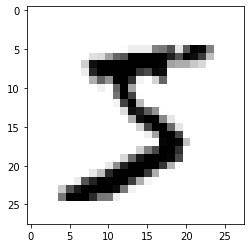

In [4]:
# Download data
sample_data = datasets.MNIST('./data', train=True, download=True).data

# Setti32ng the values in the data to be within the range [0, 1]
sample_data = sample_data.numpy() / 255

# Display some data statistics
print('Data Statistics:')
print(' - Data Shape:', sample_data.shape)
print(' - min:', np.min(sample_data))
print(' - max:', np.max(sample_data))
print(' - mean: %.4f' % np.mean(sample_data))
print(' - std: %.4f' % np.std(sample_data))
print(' - var: %.4f\n' % np.var(sample_data))

# Visualize a sample from the data
plt.imshow(sample_data[0], cmap='gray_r')

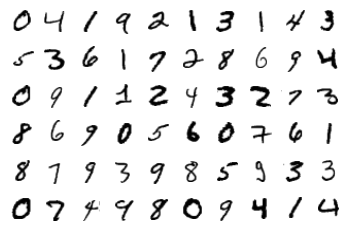

In [5]:
# Viewing more images
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(sample_data[index], cmap='gray_r')

In [6]:
# The following transformations will be used

# ToTensor
# Normalize
# Train phase transformations
train_transforms = transforms.Compose([
    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation
    # these values were obtained from the data statistics above
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
#TRAIN TEST SPLIT

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
     

In [8]:
# Train and Test Dataloaders
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
#ARCHITECTURE

class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [10]:
#MODEL PARAMETERS
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             584
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
            Conv2d-7           [-1, 16, 22, 22]           1,168
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 16, 20, 20]           2,320
             ReLU-11           [-1, 16, 20, 20]               0
      BatchNorm2d-12           [-1, 16, 20, 20]              32
        MaxPool2d-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

In [11]:
# Model Training and Evaluation


train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100 * correct / processed)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch_ID={batch_idx} Accuracy={train_accuracies[-1]:.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracies[-1]:.2f}%)\n')

In [12]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
epochs = 15

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Epoch 1:


Loss=0.09 Batch_ID=937 Accuracy=93.97: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s]



Test set: Average loss: 0.0868, Accuracy: 9807/10000 (98.07%)

Epoch 2:


Loss=0.09 Batch_ID=937 Accuracy=97.97: 100%|██████████| 938/938 [00:19<00:00, 49.30it/s]



Test set: Average loss: 0.0510, Accuracy: 9877/10000 (98.77%)

Epoch 3:


Loss=0.04 Batch_ID=937 Accuracy=98.45: 100%|██████████| 938/938 [00:18<00:00, 49.78it/s]



Test set: Average loss: 0.0399, Accuracy: 9907/10000 (99.07%)

Epoch 4:


Loss=0.02 Batch_ID=937 Accuracy=98.64: 100%|██████████| 938/938 [00:17<00:00, 53.88it/s]



Test set: Average loss: 0.0395, Accuracy: 9884/10000 (98.84%)

Epoch 5:


Loss=0.05 Batch_ID=937 Accuracy=98.75: 100%|██████████| 938/938 [00:18<00:00, 52.02it/s]



Test set: Average loss: 0.0295, Accuracy: 9924/10000 (99.24%)

Epoch 6:


Loss=0.04 Batch_ID=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 51.82it/s]



Test set: Average loss: 0.0252, Accuracy: 9940/10000 (99.40%)

Epoch 7:


Loss=0.09 Batch_ID=937 Accuracy=99.21: 100%|██████████| 938/938 [00:18<00:00, 51.29it/s]



Test set: Average loss: 0.0249, Accuracy: 9939/10000 (99.39%)

Epoch 8:


Loss=0.08 Batch_ID=937 Accuracy=99.27: 100%|██████████| 938/938 [00:18<00:00, 51.31it/s]



Test set: Average loss: 0.0249, Accuracy: 9937/10000 (99.37%)

Epoch 9:


Loss=0.01 Batch_ID=937 Accuracy=99.27: 100%|██████████| 938/938 [00:17<00:00, 52.44it/s]



Test set: Average loss: 0.0237, Accuracy: 9945/10000 (99.45%)

Epoch 10:


Loss=0.02 Batch_ID=937 Accuracy=99.29: 100%|██████████| 938/938 [00:18<00:00, 51.72it/s]



Test set: Average loss: 0.0247, Accuracy: 9940/10000 (99.40%)

Epoch 11:


Loss=0.13 Batch_ID=937 Accuracy=99.37: 100%|██████████| 938/938 [00:18<00:00, 51.04it/s]



Test set: Average loss: 0.0231, Accuracy: 9944/10000 (99.44%)

Epoch 12:


Loss=0.01 Batch_ID=937 Accuracy=99.37: 100%|██████████| 938/938 [00:17<00:00, 53.03it/s]



Test set: Average loss: 0.0237, Accuracy: 9940/10000 (99.40%)

Epoch 13:


Loss=0.04 Batch_ID=937 Accuracy=99.35: 100%|██████████| 938/938 [00:17<00:00, 52.44it/s]



Test set: Average loss: 0.0234, Accuracy: 9944/10000 (99.44%)

Epoch 14:


Loss=0.09 Batch_ID=937 Accuracy=99.35: 100%|██████████| 938/938 [00:17<00:00, 52.75it/s]



Test set: Average loss: 0.0231, Accuracy: 9941/10000 (99.41%)

Epoch 15:


Loss=0.02 Batch_ID=937 Accuracy=99.38: 100%|██████████| 938/938 [00:19<00:00, 47.39it/s]



Test set: Average loss: 0.0238, Accuracy: 9940/10000 (99.40%)



TypeError: ignored

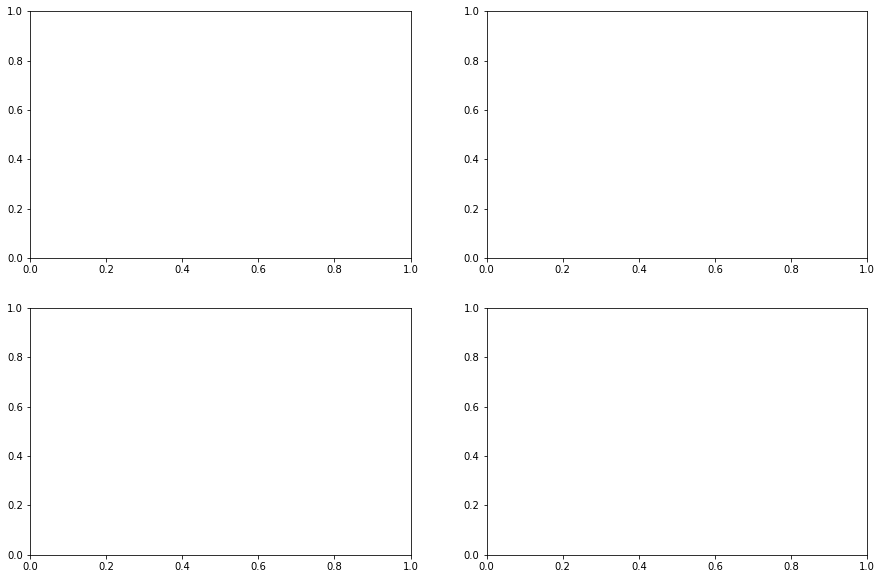

In [17]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")